In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import load_ml_data_emb
from data_manipulation.reading_util import load_non_enz_esm2


2023-12-15 10:29:14.577127: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 10:29:14.619859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 10:29:14.621325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 10:29:15.346048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Check if a GPU is available and print information about it
if tf.test.gpu_device_name():
    print('GPU found')
    print('GPU device name:', tf.test.gpu_device_name())
else:
    print('No GPU found')

No GPU found


# Loading Embeddings and labeling

In [3]:
enzyme_csv_path = os.getenv("CSV30_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_30")

non_enzymes_esm2_path = os.getenv("ESM2_NON_ENZYMES")
non_enzymes_fasta_path = os.getenv("FASTA_NON_ENZYMES")


# Load enzymes
X_enzymes, y_enzymes = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)

y_enzymes = [y-1 for y in y_enzymes]
y_enzymes = np.array(y_enzymes)


# Load non_enzymes
X_non_enzymes, y_non_enzymes = load_non_enz_esm2(non_enzymes_fasta_path=non_enzymes_fasta_path,
                             non_enzymes_esm2_path=non_enzymes_esm2_path)


print(len(X_enzymes))
print(len(X_non_enzymes))


LOG:
 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 221 entries will be ignored
['P58969', 'P58970', 'Q12TR2', 'Q6PBD1', 'Q4AEH3', 'Q6U6H1', 'Q6LH19', 'P97364', 'P32176', 'P61154', 'Q6QN11', 'Q61153', 'Q1LVN8', 'Q9L473', 'Q80TA1', 'Q9Z4Q7', 'Q17745', 'Q9R4G8', 'Q9JLV6', 'Q92F56', 'Q8YSY4', 'Q726D5', 'P17695', 'P45353', 'P9WFX1', 'P9WLZ7', 'Q05902', 'P15807', 'Q92Q90', 'O31726', 'Q2JJ30', 'Q3MEJ8', 'Q65KJ7', 'P10266', 'P00904', 'Q9LVM5', 'P94544', 'P05328', 'P22098', 'D4GW05', 'Q7Z859', 'Q4P0S6', 'B0R7U1', 'Q27828', 'Q9HZ67', 'P0DTW0', 'Q8LAD0', 'P36204', 'Q8DNB6', 'P39793', 'P25239', 'Q5WL39', 'Q61510', 'Q9ZCZ1', 'P9WNZ0', 'Q8KBX0', 'Q2KXN6', 'P07112', 'O88618', 'P53761', 'B0F481', 'K3VH30', 'Q8IKU0', 'P34277', 'Q7N6I1', 'Q9XWF0', 'Q4FUU7'

In [9]:

y_non_enzymes = [y+1 for y in y_non_enzymes]
y_non_enzymes = np.array(y_non_enzymes)


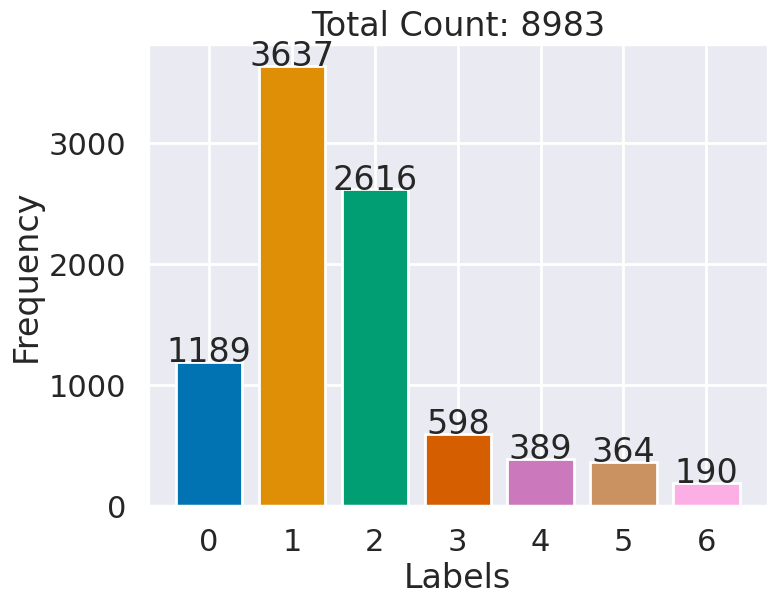

In [5]:
sns.set()
sns.set_palette("colorblind")
sns.set("poster", style="darkgrid")

y_enzymes = np.array([y+1 for y in y_enzymes])
unique, counts = np.unique(y_enzymes, return_counts=True)

# Using the colorblind palette for colors
colors = sns.color_palette("colorblind")

# Creating the bar plot with assigned colors
plt.figure(figsize=(8, 6))
bars = plt.bar(unique, counts, tick_label=unique, color=colors)

# Adding count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.1, str(count), ha='center')

# Total count of all classes
total_count = np.sum(counts)
plt.title(f'Total Count: {total_count}')

plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.show()

In [15]:
X_non_enzymes = X_non_enzymes[:4000]
y_non_enzymes = y_non_enzymes[:4000]
print(y_non_enzymes[0])

7


## Append X_n and y_n to X and y:

In [16]:
X = np.vstack((X_enzymes, X_non_enzymes))
y = np.hstack((y_enzymes, y_non_enzymes))

#y = np.array([label-1 for label in y])

In [17]:
# np.argmin(y)

y

array([2, 0, 2, ..., 7, 7, 7])

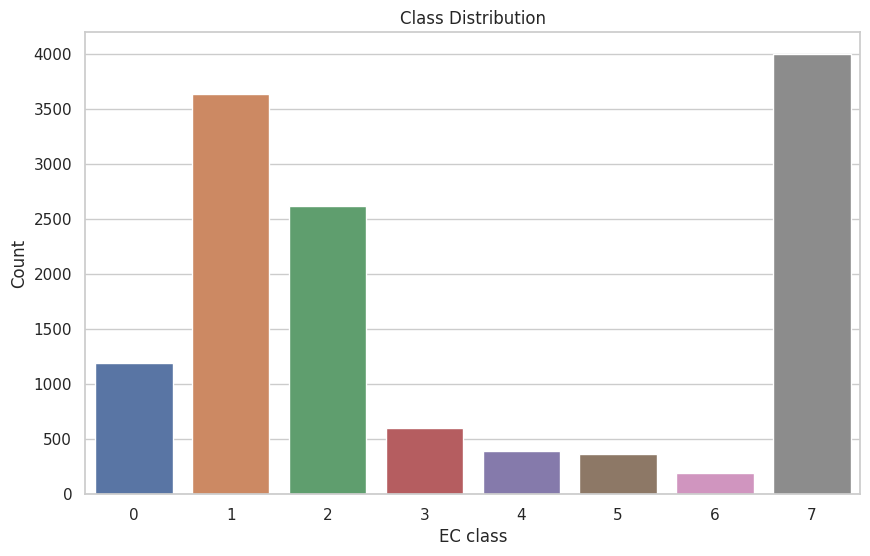

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y)

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Class Distribution")

# Show the plot
plt.show()


# Splitting data

In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=8)
print(y_test_encoded[0])

# file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models# /y_train_level_1_lables.txt"
# np.savetxt(file_path, y_train, delimiter=',', fmt='%d')


[1. 0. 0. 0. 0. 0. 0. 0.]


# Creating FNN

In [9]:
# Initializing the model
model = tf.keras.models.Sequential()

earl_stop = tf.keras.callbacks.EarlyStopping(patience=5)

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=8, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Training FNN

In [10]:
model.fit(x=X_train, y=y_train_encoded, epochs=7, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/7


2023-09-13 16:57:56.154595: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1893744640 exceeds 10% of free system memory.


5777/5780 [============================>.] - ETA: 0s - loss: 0.4534

2023-09-13 16:58:55.216305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 811612160 exceeds 10% of free system memory.


5780/5780 [==============================] - 64s 11ms/step - loss: 0.4532 - val_loss: 0.1621
Epoch 2/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.2294 - val_loss: 0.1271
Epoch 3/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1927 - val_loss: 0.1142
Epoch 4/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1691 - val_loss: 0.1076
Epoch 5/7
5780/5780 [==============================] - 62s 11ms/step - loss: 0.1538 - val_loss: 0.0962
Epoch 6/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1433 - val_loss: 0.0918
Epoch 7/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1353 - val_loss: 0.0899


# Evaluation

# Testing Optuna for hyperparams

In [44]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 256)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 64)
    
    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)
    
    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
    
    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=35, callbacks=[early_stop], verbose=0)
    
    # Get the best validation loss
    val_loss = min(history.history['val_loss'])
    
    return val_loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=45)  # You can adjust the number of trials as needed

[I 2023-12-11 23:49:40,446] A new study created in memory with name: no-name-1cb319eb-8d81-4dc7-9680-c539c5f55921
[I 2023-12-11 23:52:51,507] Trial 0 finished with value: 0.22103217244148254 and parameters: {'num_units_dense_1': 186, 'dropout_rate_1': 0.5273300675479486, 'num_units_dense_2': 55}. Best is trial 0 with value: 0.22103217244148254.
[I 2023-12-11 23:55:05,360] Trial 1 finished with value: 0.2230454534292221 and parameters: {'num_units_dense_1': 173, 'dropout_rate_1': 0.23163331682978514, 'num_units_dense_2': 52}. Best is trial 0 with value: 0.22103217244148254.
[I 2023-12-11 23:56:43,243] Trial 2 finished with value: 0.22874528169631958 and parameters: {'num_units_dense_1': 32, 'dropout_rate_1': 0.21692099686112118, 'num_units_dense_2': 47}. Best is trial 0 with value: 0.22103217244148254.
[I 2023-12-11 23:59:16,248] Trial 3 finished with value: 0.22602422535419464 and parameters: {'num_units_dense_1': 250, 'dropout_rate_1': 0.06618252793626837, 'num_units_dense_2': 56}. Be

[I 2023-10-15 10:50:52,605] Trial 21 finished with value: 0.46775954961776733 and parameters: {'num_units_dense_1': 435, 'dropout_rate_1': 0.6271616990140565, 'num_units_dense_2': 214, 'dropout_rate_2': 0.11491633226586015, 'num_units_dense_3': 90}. Best is trial 21 with value: 0.46775954961776733.

Trial 23 finished with value: 0.442497581243515 and parameters: {'num_units_dense_1': 435, 'dropout_rate_1': 0.6283712630836917, 'num_units_dense_2': 157, 'dropout_rate_2': 0.34594360535817104, 'num_units_dense_3': 107}. Best is trial 23 with value: 0.442497581243515.

In [20]:
# best_num_units_dense_1 = 435
# best_dropout_rate_1 = 0.6283712630836917
# best_num_units_dense_2 = 157
# best_dropout_rate_2 = 0.34594360535817104
# best_num_units_dense_3 = 107

# less nodes 1
#[I 2023-12-11 21:47:29,653] Trial 17 finished with value: 0.23831643164157867 and parameters: {'num_units_dense_1': 212, 'dropout_rate_1': 0.34140714797987826, 'num_units_dense_2': 36}. Best is trial 17 with value: 0.23831643164157867. 


# less nodes 2
#{'num_units_dense_1': 255, 'dropout_rate_1': 0.6763562286580183, 'num_units_dense_2': 32} 

# best_params = study.best_params
best_params = {'num_units_dense_1': 255, 'dropout_rate_1': 0.6763562286580183, 'num_units_dense_2': 32} 
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

final_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=100, callbacks=[early_stop], verbose=1)

Epoch 1/100


2023-12-15 10:40:03.174830: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93061120 exceeds 10% of free system memory.


281/284 [============================>.] - ETA: 0s - loss: 1.3629 - accuracy: 0.5041

2023-12-15 10:40:06.968093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39884800 exceeds 10% of free system memory.


284/284 [==============================] - 4s 12ms/step - loss: 1.3607 - accuracy: 0.5056 - val_loss: 1.0682 - val_accuracy: 0.6434
Epoch 2/100
284/284 [==============================] - 3s 11ms/step - loss: 1.0426 - accuracy: 0.6396 - val_loss: 0.8607 - val_accuracy: 0.7330
Epoch 3/100
284/284 [==============================] - 3s 12ms/step - loss: 0.8772 - accuracy: 0.7055 - val_loss: 0.7684 - val_accuracy: 0.7517
Epoch 4/100
284/284 [==============================] - 3s 11ms/step - loss: 0.7698 - accuracy: 0.7480 - val_loss: 0.6727 - val_accuracy: 0.7949
Epoch 5/100
284/284 [==============================] - 3s 11ms/step - loss: 0.6892 - accuracy: 0.7788 - val_loss: 0.6059 - val_accuracy: 0.8136
Epoch 6/100
284/284 [==============================] - 3s 11ms/step - loss: 0.6309 - accuracy: 0.7956 - val_loss: 0.5986 - val_accuracy: 0.8159
Epoch 7/100
284/284 [==============================] - 3s 11ms/step - loss: 0.5830 - accuracy: 0.8066 - val_loss: 0.5685 - val_accuracy: 0.8223
Epoc

<Figure size 1000x600 with 0 Axes>

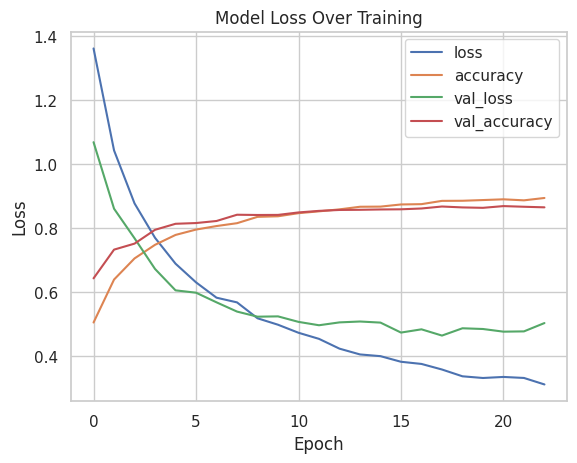

In [21]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [22]:
predictions = np.argmax(final_model.predict(X_val), axis=-1)

counter = 0
for x,y in zip(y_val,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_val))

 24/122 [====>.........................] - ETA: 0s

2023-12-15 10:42:08.851206: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39884800 exceeds 10% of free system memory.


122/122 [==============================] - 0s 3ms/step
Correct predictions:  3369
Total samples predicted: 3895


In [23]:
report = classification_report(y_val, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       355
           1       0.88      0.90      0.89      1095
           2       0.88      0.88      0.88       804
           3       0.75      0.49      0.60       182
           4       0.77      0.61      0.68       122
           5       0.88      0.80      0.84       101
           6       0.84      0.60      0.70        63
           7       0.88      0.94      0.91      1173

    accuracy                           0.86      3895
   macro avg       0.84      0.76      0.79      3895
weighted avg       0.86      0.86      0.86      3895


In [24]:
final_model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/1512_opt_less_nodes_1.keras")
